In [1]:
import os.path as os
import cv2 as cv
import matplotlib.pyplot as plt
'''화상데이터_어노테이션데이터_파일경로 생성'''

'화상데이터_어노테이션데이터_파일경로 생성'

# 함수 작성: 데이터 경로를 저장하는 리스트 

return : 
        
        train_img_list 학습 이미지 경로 리스트

        train_anno_list 학습 어노테이션 경로 리스트

        val_img_list 검증 이미지 경로 리스트

        val_anno_list 검증 어노테이션 경로 리스트

In [2]:
def make_datapath_list(rootpath:str):
    '''
    데이터 경로를 저장한 리스트 작성

    Parameters
    ----------

    rootpath: str
        데이터 폴더 경로
        
    Returns
    ----------
    ret: train_img_list, train_anno_list, val_img_list, val_anno_list
        데이터 경로를 저장한 리스트
    '''

    # 화상 파일과 어노테이션 파일의 경로 템플릿 작성
    imgpath_template=os.join(rootpath + 'JPEGImages', '%s.jpg')
    annopath_template=os.join(rootpath + 'Annotations', '%s.xml')

    # 훈련 및 검증 파일 ID(파일 이름) 취득
    train_id_names=os.join(rootpath + 'ImageSets/Main/train.txt')
    val_id_names=os.join(rootpath + 'ImageSets/Main/val.txt')

    # 훈련 데이터의 화상 파일과 어노테이션 파일의 경로 리스트 작성
    train_img_list = list()
    train_anno_list = list()

    for line in open(train_id_names):
        file_id = line.strip() # 공백과 줄 바꿈 제거
        img_path = (imgpath_template % file_id) # 화상 경로
        anno_path = (annopath_template % file_id) # 어노테이션 경로
        train_img_list.append(img_path) # 리스트에 화상경로 추가
        train_anno_list.append(anno_path) # 리스트에 어노테이션 경로 추가\

    val_img_list = list()
    val_anno_list = list()
    
    for line in open(val_id_names):
        file_id = line.strip()
        img_path= (imgpath_template % file_id)
        anno_path= (annopath_template % file_id)
        val_img_list.append(img_path)
        val_anno_list.append(anno_path)

    return train_img_list, train_anno_list, val_img_list, val_anno_list

In [3]:
rootpath='C:/Users/hyssk/Myopencv/DeepLearningVision/SSD/data/'
train_img_list, train_anno_list, val_img_list, val_anno_list=make_datapath_list(rootpath=rootpath)
print(train_img_list[0])


C:/Users/hyssk/Myopencv/DeepLearningVision/SSD/data/JPEGImages\2008_000008.jpg


# XML 형식의 어노테이션 데이터를 리스트로 변환하기

    XML 어노테이션 내부에 있는 정보들 추출 (Image와 Label과 bbox)

In [4]:
'''XML 형식의 어노테이션 데이터를 리스트로 변환하기'''
import xml.etree.ElementTree as ET
import numpy as np

In [5]:
class Anno_xml2list(object):
    '''
    한 화상의 XML 형식 어노테이션 데이터를 화상 크기로 규격화하여 리스트 형식으로 변환
    
    Attributes
    ----------
    classes: 리스트
        VOC의 클래스명을 저장한 리스트
    '''

    def __init__(self, classes):
        self.classes=classes
    
    def __call__(self,xml_path,width,height):
        '''
        한 화상의 XML 형식 어노테이션 데이터를 화상 크기로 규격화하여 리스트 형식으로 변환

        Parameters
        ----------
        xml_path: str
            xml 파일 경로
        width: int
            대상 화상 폭
        height: int
            대상 화상 높이
        
        Returns
        ----------
        ret : [[xmin,ymin,xmax,ymax,label_ind],...]
            물체의 어노테이션 데이터를 저장한 리스트. 화상에 존재하는 물체 수만큼의 요소를 가진다.
        '''
        # 화상 내 모든 물체의 어노테이션을 이 리스트에 저장
        ret=[]

        # xml 파일 로드
        xml = ET.parse(xml_path).getroot()
        # 화상 내 물체(object) 수만큼 반복
        for obj in xml.iter('object'):
            # 어노테이션에서 검지가 difficult로 설정된 것은 제외
            difficult = int(obj.find('difficult').text)
            if difficult == 1:
                continue

            # 한 물체의 어노테이션을 저장하는 리스트
            bndbox=[]
            name = obj.find('name').text.lower().strip()
            bbox = obj.find('bndbox') # 바운딩 박스 정보

            # 어노테이션의 xmin, ymin, xmax, ymax를 취득하고 0~1으로 규격화
            pts = ['xmin','ymin','xmax','ymax']

            for pt in (pts):
                # VOC는 원점이 (1,1)이므로 1을 빼서 (0,0) 으로 한다.
                cur_pixel=int(bbox.find(pt).text) - 1
                # 폭, 높이로 규격화
                if pt == 'xmin' or pt == 'xmax':
                    cur_pixel/=width
                
                else:  # y 방향의 경우 높이로 나눈다.
                    cur_pixel /= height
                bndbox.append(cur_pixel)

            # 어노테이션의 클래스명 index를 취득하여 추가
            label_idx = self.classes.index(name)
            bndbox.append(label_idx)

            ret+=[bndbox]
        return np.array(ret)

(442, 500, 3)

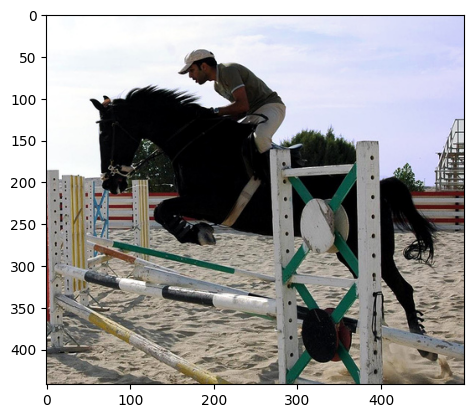

In [38]:
voc_classes=['aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow',
             'diningtable','dog','horse','motorbike','person','pottedplant','sheep','sofa',
             'train','tvmonitor']

transform_anno=Anno_xml2list(voc_classes) # Anno_xml2list 인스턴스 생성
image_file_path=train_img_list[0]

img=cv.imread(image_file_path) # BGR
img=cv.cvtColor(img,cv.COLOR_BGR2RGB) # BGR -> RGB
height,width,channels=img.shape # [높이][폭][색BGR(채널)]
transform_anno(train_anno_list[0],width,height) #  인스턴스의 입력(xml 경로, width, height) | return: [xmin, ymin, xmax, ymax, label]
plt.imshow(img) # RGB


# DataTransform() 은 YutaroOgawa에서 가져온 utility 이다.

DataTransform()의 Function을 가져오고 

In [40]:
from utils.data_augumentation import Compose, ConvertFromInts, ToAbsoluteCoords, PhotometricDistort,Expand,RandomSampleCrop, RandomMirror,ToPercentCoords,Resize,SubtractMeans
'''util 폴더는 github.com/YutaroOgawa 에서 가져왔습니다.
    입력 영상의 전처리 클래스
'''

class DataTransform():
    """
    화상과 어노테이션의 전처리 클래스, 훈련과 추론에서 다르게 작동
    화상 크기를 300*300으로 해야한다.
    학습 시 데이터 데이터 확장을 수행한다.

    Attributes 
    ----------
    input_size: int
        리사이즈 대상 화상의 크기
    color_mean: (B,G,R)
        각 색상 채널의 평균값
    """

    def __init__(self,input_size,color_mean):
        self.data_transform = {
            'train':Compose([
                ConvertFromInts(), # int를 Float32로 변환
                ToAbsoluteCoords(), # 어노테이션 데이터의 규격화 반환
                PhotometricDistort(), # 화상의 색조 등 임의로 변환
                Expand(color_mean),# 화상의 캔버스 확대
                RandomSampleCrop(), # 화상 내의 특정 부분 무작위 추출
                RandomMirror(), # 화상 반전
                ToPercentCoords(), # 어노테이션 데이터를 0~1로 규격화
                Resize(input_size), # 화상 크기를 input_size * input_size로 변형
                SubtractMeans(color_mean) # BGR 색상의 평균값 빼기
            ]),
            'val': Compose([
                ConvertFromInts(), #int를 float로 변환
                Resize(input_size), # 화상 크기를 input_size * input_size로 변형
                SubtractMeans(color_mean) # BGR 색상의 평균값 빼기
            ])
        }
    def __call__(self,img,phase,boxes,labels): # 클래스 객체를 부르면 return 함
        '''
        Parameters
        ----------
        phase: 'train' or 'val'
            전처리 모드 지정
        '''
        return self.data_transform[phase](img,boxes,labels)

width: 500
height: 442


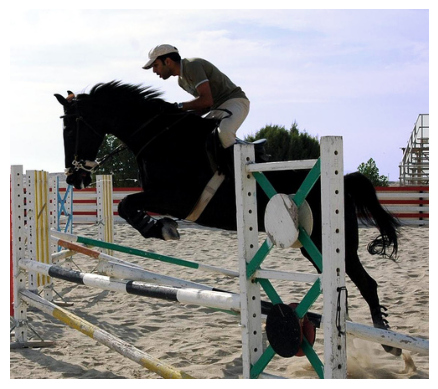

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


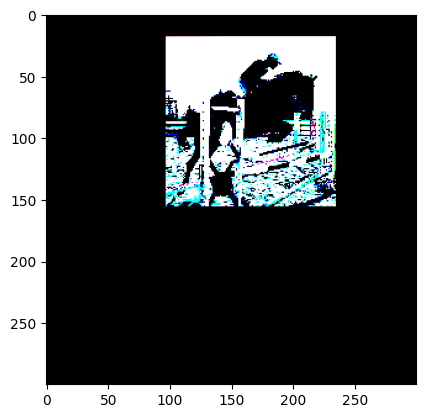

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


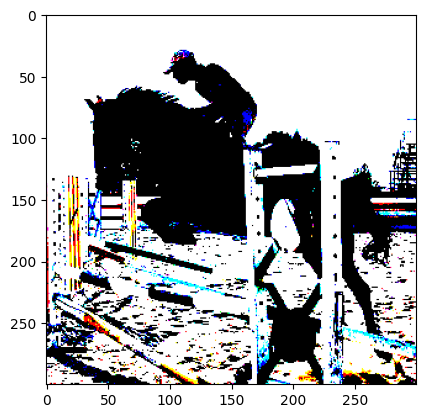

In [55]:
# 1. 화상 읽기
image_file_path=train_img_list[0]
img=cv.imread(image_file_path) # [높이][폭][색BGR]
height,width,channels=img.shape # 화상 크기 취득
print(f'width: {width}')
print(f'height: {height}')

# 2. 어노테이션을 리스트로 
transform_anno = Anno_xml2list(voc_classes)
anno_list = transform_anno(train_anno_list[0],width,height) 

# 3. 원본 표시
plt.imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))
plt.axis(False)
plt.show()

# 4. 전처리 클래스 작성
color_mean = (104,117,123) # (BGR) 색상의 평균값
input_size = 300 # 화상의 input_size를 300*300
transform = DataTransform(input_size=input_size, color_mean=color_mean) # 클래스 객체 생성

# 5. Train 화상 표시
phase = 'train'
img_transformed, boxes, labels = transform(img, phase, anno_list[:, :4], anno_list[:,4])
plt.figure()
plt.imshow(cv.cvtColor(np.clip(img_transformed,0,255),cv.COLOR_BGR2RGB))
plt.show()

# 6. Val 화상 표시
phase = 'val'
img_transformed, boxes, labels = transform(img, phase, anno_list[:,:4],anno_list[:,4])
plt.figure()
plt.imshow(cv.cvtColor(np.clip(img_transformed,0,255),cv.COLOR_BGR2RGB))
plt.show()


# Dataset 작성 

In [9]:
'''데이터셋 작성'''
from torch.utils.data import Dataset
import torch

In [10]:
class VOCDataset(Dataset):
    """
    VOC2012의 Dataset을 만드는 클래스. 파이토치의 Dataset 클래스를 상속한다.

    Attributes
    ----------
    img_list: 리스트
        화상경로를 저장한 리스트
    anno_list: 리스트
        어노테이션 경로를 저장한 리스트
    phase: 'train' or 'val'
        학습 또는 훈련 설정
    transform: object
        전처리 클래스의 인스턴스
    transform_anno: object
        xml 어노테이션을 리스트로 변환하는 인스턴스
    """
    def __init__(self,img_list,anno_list,phase,transform,transform_anno):
        self.img_list = img_list
        self.anno_list= anno_list
        self.phase = phase
        self.transform = transform
        self.transform_anno=transform_anno

    def __len__(self):
        '''화상의 개수 반환'''
        return len(self.img_list)
    
    def __getitem__(self,index):
        '''
        전처리한 화상의 텐서 형식 데이터와 어노테이션 획득
        '''
        im,gt,h,w=self.pull_item(index)
        return im,gt
    
    def pull_item(self,index):
        '''전터리한 화상의 텐서 형식 데이터, 어노테이션, 화상의 높이, 폭 취득'''
        # 1. 화상 읽기
        image_file_path = self.img_list[index]
        img = cv.imread(image_file_path) #[높이][너비][색BGR]
        height,width,channels=img.shape # 화상 크기 취득

        # 2. xml 형식의 어노테이션 정보를 리스트에 저장
        anno_file_path = self.anno_list[index]
        anno_list = self.transform_anno(anno_file_path,width,height)

        # 3. 전처리 실시
        img, boxes, labels = self.transform(
            img,self.phase,anno_list[:,:4],anno_list[:,4]
        )
        # 색상 채널의 순서가 BGR 이므로 RGB로 변경
        img = torch.from_numpy(img[:,:,(2,1,0)]).permute(2,0,1)

        # BBOX와 라벨을 세트로 한 np.array를 작성. 변수 이름 gt는 ground truth의 약칭
        gt = np.hstack((boxes,np.expand_dims(labels,axis=1)))

        return img, gt, height, width

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


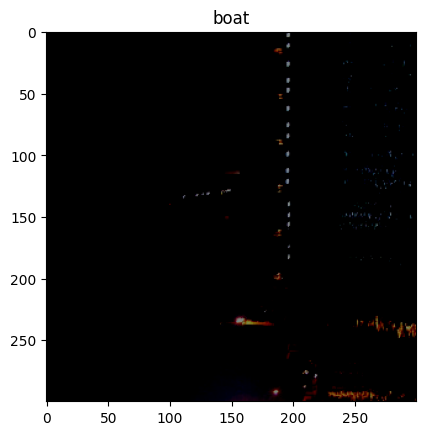

5823


In [63]:
color_mean = (104,117,123) # (BGR) 색상의 평균값
input_size = 300 # 화상의 input_size를 300*300
train_dataset=VOCDataset(train_img_list,
                          train_anno_list,
                          phase='train',
                          transform=DataTransform(input_size,color_mean),
                          transform_anno=Anno_xml2list(voc_classes))

val_dataset=VOCDataset(val_img_list,
                       anno_list=val_anno_list,
                       phase='val',
                       transform=DataTransform(input_size,color_mean),
                       transform_anno=Anno_xml2list(voc_classes))
plt.figure()
plt.imshow(val_dataset.__getitem__(2)[0].type(torch.LongTensor).permute(2,1,0))
plt.title(voc_classes[int(val_dataset.__getitem__(2)[1][:,4][0])])
plt.show()
print(len(val_dataset))

# DataLoader 구현

화상 데이터마다 Dataset에서 꺼낼 어노테이션 데이터 정보, gt 변수의 크기(화상 내의 물체 수)가 다르다.

Dataset에서 꺼내는 변수의 크기가 데이터마다 다르다면 Dataloader 클래스에서 기본적으로 사용하는 데이터 추출 함수인 collate_fn를 별도로 만들어야한다.

데이터 추출 함수인 od_collate_fn을 만든다.

In [65]:
def od_collate_fn(batch):
    '''
    Dataset에서 꺼내는 어노테이션 데이터의 크기는 화상마다 다름.
    화상 내의 물체 수가 두개이면 (2,5) 사이즈 [xmin, ymin, xmax, ymax, label]이 2개, 
    물체 수가 3개 이면 (3,5) 사이즈 [Xmin, Xmax, ymin, ymax, label]가 3개
    변화에 대응하는 DataLoader를 만드는 collate_fn을 작성
    collate_fn은 파이토치 리스트로 mini_batch를 작성하는 함수이다.
    '''
    targets=[]
    imgs=[]
    for sample in batch:
        imgs.append(sample[0]) # sample[0]은 화상 이미지
        targets.append(torch.FloatTensor(sample[1])) # sample[1]은 어노테이션 gt
    
    # imgs는 미니 배치 크기의 리스트
    # 리스트 요소는 torch.Size([3,300,300])
    # 이 리스트를 torch.Size([batch_num,3,300,300])의 텐서로 변환
    imgs=torch.stack(imgs,dim=0)

    # targets은 어노테이션의 정단인 gt리스트
    # 리스트 크기 = 미니 배치 크기
    # targets 리스트의 요소는 [n,5]
    # n은 화상 속 물체의 개수
    # 5는 [xmin, ymin, xmax, ymax, label]
    return imgs, targets

In [75]:
# 데이터 로더 작성
from torch.utils.data import DataLoader

batch_size = 4 
train_dataloader = DataLoader(train_dataset,batch_size,True,collate_fn=od_collate_fn)

val_dataloader= DataLoader(val_dataset,batch_size,False, collate_fn=od_collate_fn)

dataloader_dict =  {'train': train_dataloader, 'val': val_dataloader}

batch_iterator= iter(dataloader_dict['val'])

images, targets = next(batch_iterator)

print(images.size())
print(len(targets))
print(targets[1].size())

torch.Size([4, 3, 300, 300])
4
torch.Size([2, 5])


In [78]:
print(len(train_dataset))
print(len(val_dataset))

print(len(train_dataloader))
print(len(val_dataloader))

5717
5823
1430
1456
